## 1.0 Colisiones 2D de duración finita

Modelo de esfera dura donde $R_{1}$, $R_{2}$ son los radios de las esferas y $\vec{n}$ es el vector normal al plano de contacto. Usar $K = 100 \frac{N}{m^3}$  
  
$\vec{f}(\vec{r_{1}},\vec{r_{2}}) = \left\lbrace\begin{array}{c} K|\vec{r_{1}}-\vec{r_{2}}|^3 \vec{n} ~~~~ si~~~~ |\vec{r_{1}}-\vec{r_{2}}|< R_{1} + R_{2}\\0 ~~~~~~~~En ~otro~ caso \end{array}\right. $

#### a) ¿Cuál es el significado físico de K?
En la ecuación anterior K sería la magnitud de la fuerza que siente una esfera con respecto a la otra, esa magnitud está asociada con la fuerza por unidad de volumen, es decir, K sería la fuerza relacionada a la deformación de las esferas (compresión).    

In [63]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

In [64]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        
        self.m = m
        self.radius = radius
        self.Id = Id
        self.kVector = np.zeros( (len(t),1 ))
        self.uVector = np.zeros( (len(t),1 ))
        self.fuerza = self.m * self.a
        self.k = 100.
        self.u = 0.
        
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetK(i, self.GetEnK())
        self.SetU(i, self.GetEnU())
        
        #Aceleración
        self.a = self.fuerza / self.m
        
        #Euler Method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
        
    def CheckWallLimits(self,limits,dim=2):
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
                
    def reinicio(self):
        self.fuerza[:]= 0.
        self.a[:] = 0.
        self.u = 0.
        
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
    
    def SetU(self,i,u):
        self.uVector[i] = u
    
    def SetK(self,i,k):
        self.kVector[i] = k
        
        
    # Getters  
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    

    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def GetFuerza(self):
        return self.fuerza
                                
    def GetEnK(self):
        k = 0.5 * self.m * np.linalg.norm(self.v)**2
        return k
    
    def GetEnU(self):
        u = (self.u/2)/2
        return u
    
    def choque(self,p):
        d = self.r - p.GetPosition()
        r12 = np.linalg.norm(d)
        ch = (p.GetR() + self.radius) - r12 

        if ch >0:
            fuerza = (self.k * (ch**3)) / r12
            self.fuerza = np.add(self.fuerza, d * fuerza)
            self.u += self.k * (ch**4)/4  
            
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]]) # initial condition
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

                


In [65]:
# Discretization
dt = 0.0001
tmax = 10
t = np.arange(0,tmax+dt,dt)

In [78]:
x01 = np.array( [-15.,0.] )
v01 = np.array( [20.,0.] )
a01 = np.array( [0.,0] )      
p1 = Particle(x01,v01,a01,t,1.,2.0,1)

x02 = np.array( [0.,-1.6] )
v02 = np.array( [0.,0.] )
a02 = np.array( [0.,0.] )       
p2 = Particle(x02,v02,a02,t,1.,2.0,1)

x03 = np.array( [-13.,-15.] )
v03 = np.array( [0.,0.] )
a03 = np.array( [0.,0.] )        
p3 = Particle(x03,v03,a03,t,1.,2.0,1)
Particles = np.array([p1,p2,p3])


In [79]:
Limits = np.array([20.,20.])

In [80]:
def RunSimulation(t):
    part = Particles 
    for it in tqdm(range(len(t))): # Evolucion temporal
        for p in range(len(part)):
            for pp in range(len(part)):
                if p != pp:
                    part[p].choque(part[pp])
        for p in range(len(part)):
            part[p].Evolution(it)
            part[p].reinicio()
            part[p].CheckWallLimits(Limits)
    return part

In [81]:
Particles = RunSimulation(t)


100%|████████████████████████████████████████████████████████████████████████| 100001/100001 [00:17<00:00, 5775.08it/s]


In [82]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

redt = ReduceTime(t,500)


<IPython.core.display.Javascript object>


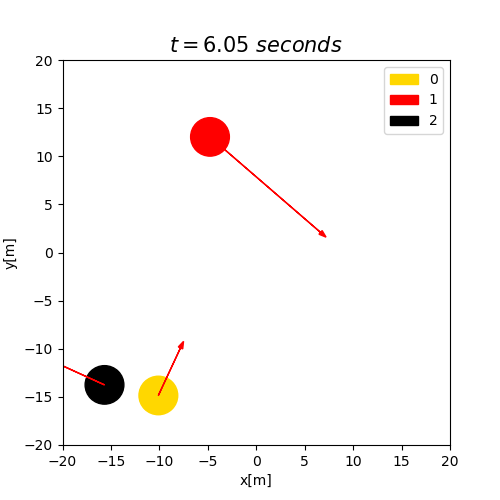

In [83]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    ax.set_xlabel('x[m]')
    ax.set_ylabel('y[m]', rotation=90)
    c = 0
    colores = ["gold","r","k"] 
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]

        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        circle = plt.Circle( (x,y), p.GetR(), color=np.take(colores,c), fill=True,label=c)
        c += 1
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        plt.legend()
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

Las coordenadas para la posición de inicio de la partícula roja para hacer carambola (tocar en un solo tiro las otras dos bolas y también 3 bandas (paredes)) podrían ubicarse en el rango de $x = [-15,-5]$ y $y = 0$ 

### Energías

<IPython.core.display.Javascript object>


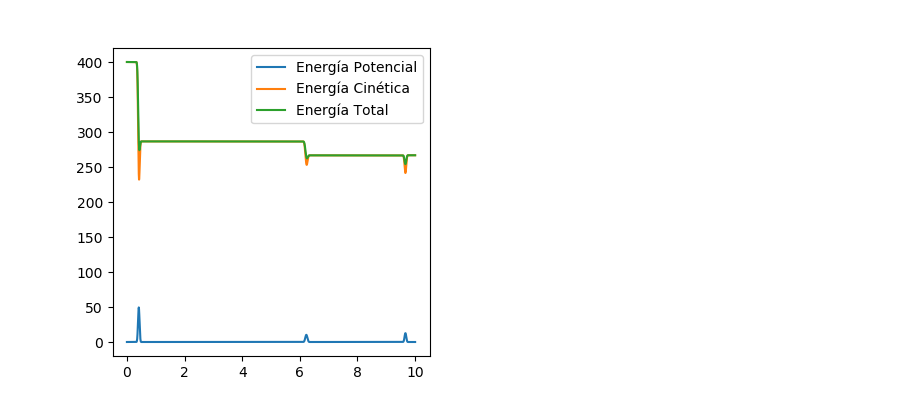

In [58]:
potencial = Particles[0].uVector
cinetica = Particles[0].kVector
total = potencial + cinetica

for p in range(len(Particles)):
    potencial = np.add(potencial, Particles[p].uVector)
    cinetica = np.add(cinetica, Particles[p].kVector)
    total = np.add(total, Particles[p].uVector + Particles[p].kVector)

fig2 = plt.figure(figsize=(9,4))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(t, potencial, label="Energía Potencial")
ax1.plot(t, cinetica, label="Energía Cinética")
ax1.plot(t, total, label="Energía Total")
ax1.legend()
plt.show()